# **Implementation of a Self-Attention-Based Persian-to-English Translation Model Using PyTorch**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
This Project implements a sequence-to-sequence translation model using a self-attention mechanism to translate sentences from Persian (Farsi) to English. The model is trained on a small dataset of 50 Persian-English sentence pairs. The data is preprocessed using tokenizers for Persian and English, and vocabularies are built for both languages. The input and target sequences are padded to ensure uniform length.

The model consists of an embedding layer, a single self-attention layer, and a fully connected output layer. It is trained using the Adam optimizer and CrossEntropyLoss, with padding tokens ignored during loss calculation. Training is performed over 100 epochs, and the model is evaluated on a test sentence to predict its English translation. The implementation demonstrates the core concepts of building and training a self-attention-based translation model, although the small dataset limits its generalization capability.
    </font>
</div>

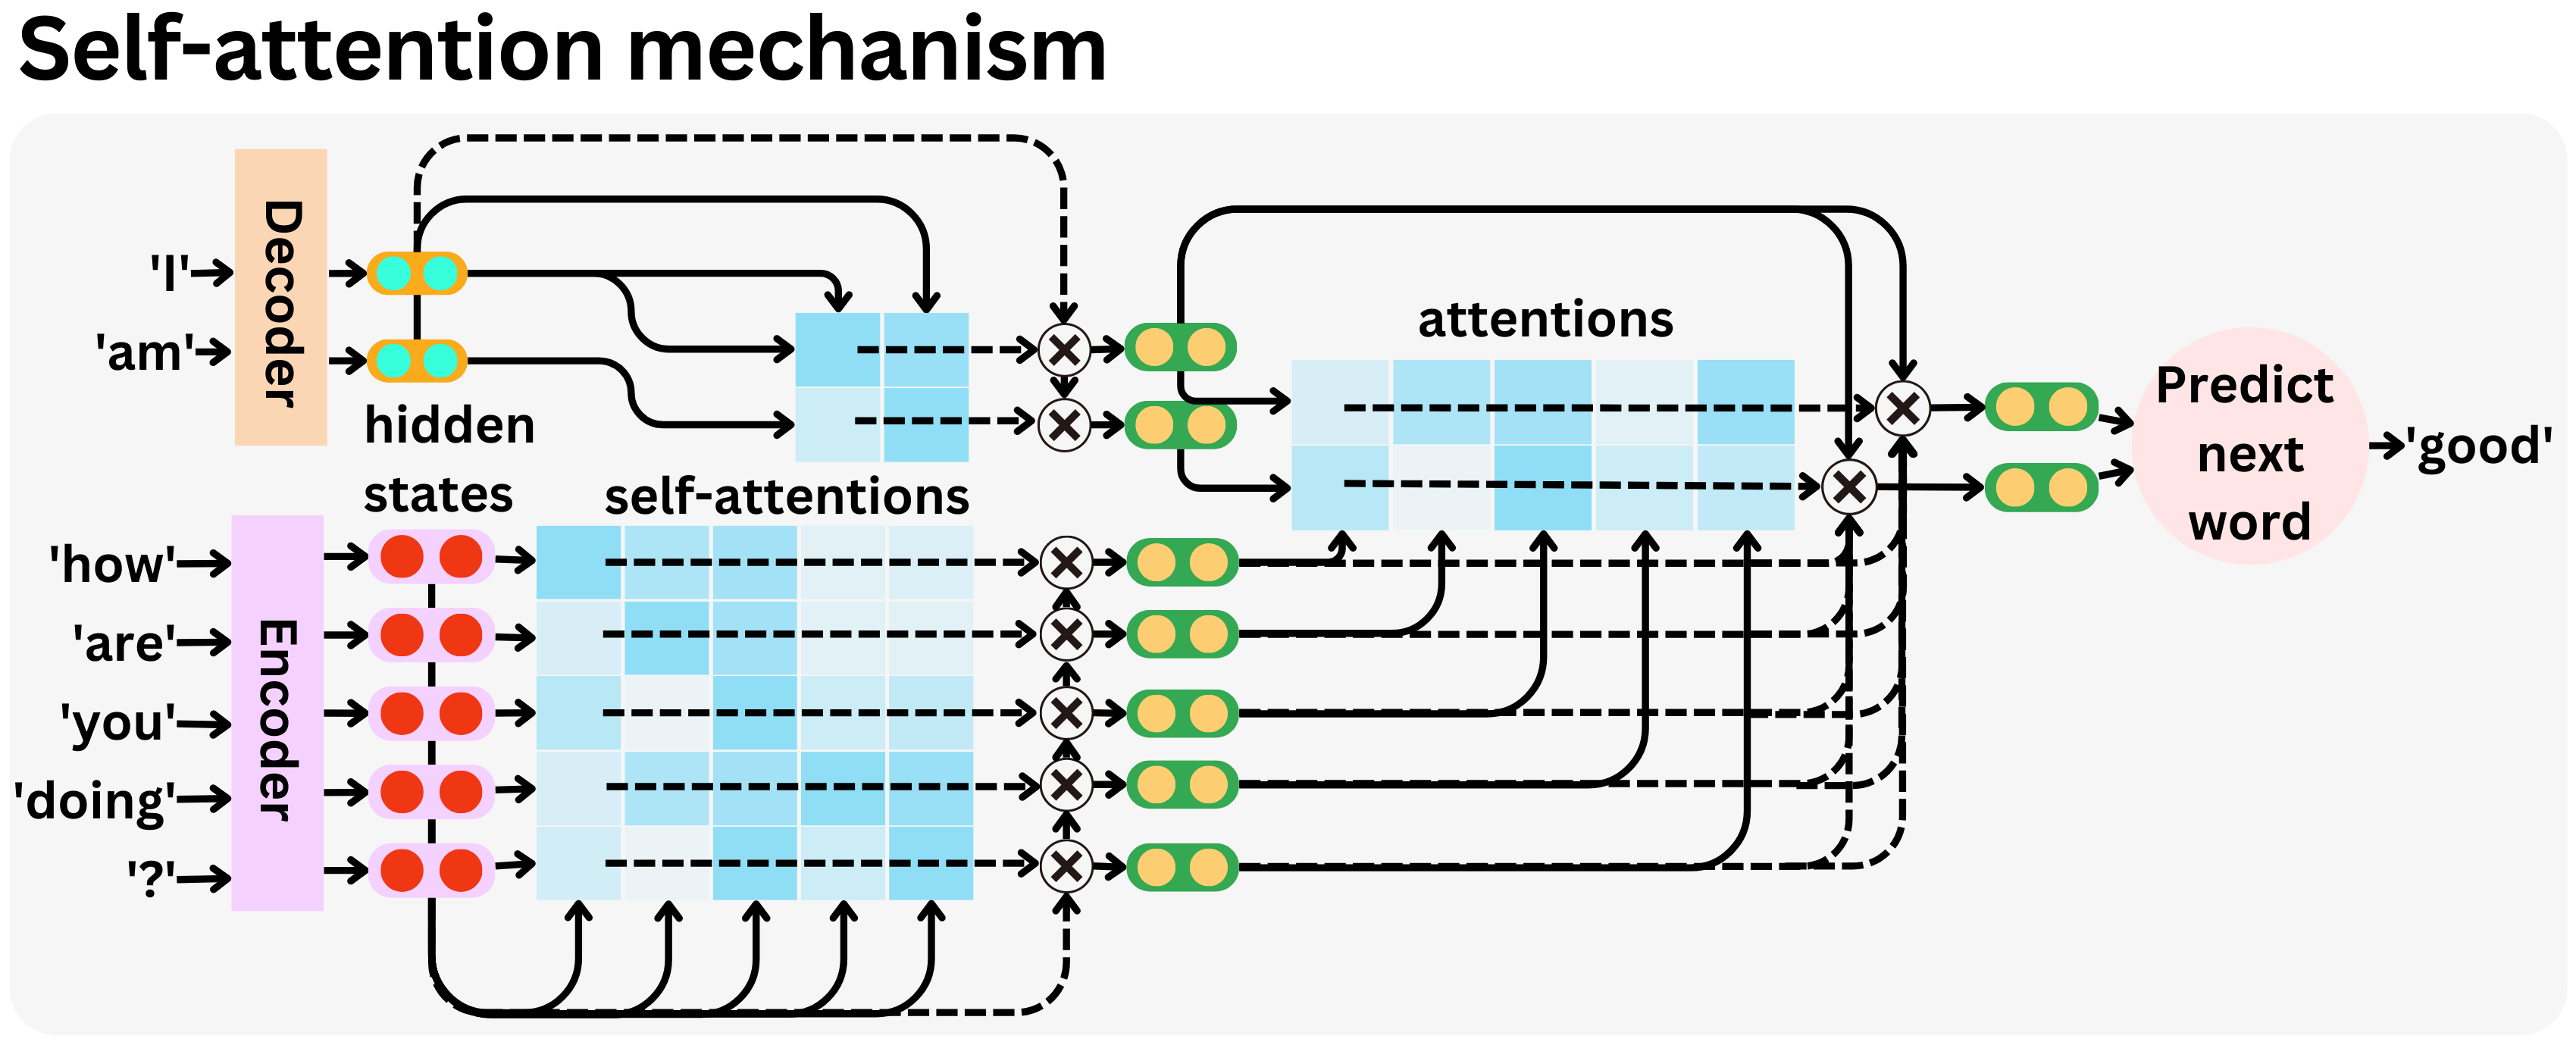

In [29]:
%%capture
!pip install spacy
!pip install hazm
!pip install nltk

## **1. Import Libraries**

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from hazm import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

## **2. Sample Data**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Defines a small dataset of 50 Persian-English sentence pairs for training the translation model.
    </font>
</div>

In [31]:
data = [
    ("او به دانشگاه رفت", "He went to university"),
    ("من کتاب خواندم", "I read a book"),
    ("آنها فوتبال بازی کردند", "They played football"),
    ("ما به پارک رفتیم", "We went to the park"),
    ("تو غذا خوردی", "You ate food"),
    ("او به مدرسه رفت", "He went to school"),
    ("من فیلم تماشا کردم", "I watched a movie"),
    ("آنها به سینما رفتند", "They went to the cinema"),
    ("ما در کلاس درس خواندیم", "We studied in class"),
    ("تو به فروشگاه رفتی", "You went to the store"),
    ("او با دوستانش بازی کرد", "He played with his friends"),
    ("من به خانه آمدم", "I came home"),
    ("آنها در پارک قدم زدند", "They walked in the park"),
    ("ما به رستوران رفتیم", "We went to the restaurant"),
    ("تو آب خوردی", "You drank water"),
    ("او به کتابخانه رفت", "He went to the library"),
    ("من به مهمانی رفتم", "I went to the party"),
    ("آنها در خانه ماندند", "They stayed at home"),
    ("ما به ساحل رفتیم", "We went to the beach"),
    ("تو به کلاس رفتی", "You went to class"),
    ("او به بیمارستان رفت", "He went to the hospital"),
    ("من به مسافرت رفتم", "I went on a trip"),
    ("آنها در کافه نشستند", "They sat in the cafe"),
    ("ما به کوه رفتیم", "We went to the mountain"),
    ("تو به مهمانی دعوت شدی", "You were invited to the party"),
    ("او به فروشگاه رفت", "He went to the shop"),
    ("من به ورزشگاه رفتم", "I went to the gym"),
    ("آنها به موزه رفتند", "They went to the museum"),
    ("ما به شهر رفتیم", "We went to the city"),
    ("تو به مدرسه رفتی", "You went to school"),
    ("او به خانه برگشت", "He returned home"),
    ("من به دفتر کار رفتم", "I went to the office"),
    ("آنها به فرودگاه رفتند", "They went to the airport"),
    ("ما به ایستگاه قطار رفتیم", "We went to the train station"),
    ("تو به پارک رفتی", "You went to the park"),
    ("او به کلیسا رفت", "He went to the church"),
    ("من به مسجد رفتم", "I went to the mosque"),
    ("آنها به تئاتر رفتند", "They went to the theater"),
    ("ما به کنسرت رفتیم", "We went to the concert"),
    ("تو به کتابخانه رفتی", "You went to the library"),
    ("او به مدرسه موسیقی رفت", "He went to the music school"),
    ("من به کلاس رفتم", "I went to class"),
    ("آنها به استادیوم رفتند", "They went to the stadium"),
    ("ما به نمایشگاه رفتیم", "We went to the exhibition"),
    ("تو به سینما رفتی", "You went to the cinema"),
    ("او به رستوران رفت", "He went to the restaurant"),
    ("من به کافی‌شاپ رفتم", "I went to the coffee shop"),
    ("آنها به هتل رفتند", "They went to the hotel"),
    ("ما به فروشگاه رفتیم", "We went to the store"),
    ("تو به مدرسه رفتی", "You went to school")
]

## **3. Tokenizers**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Tokenizes Persian sentences using hazm and English sentences using a simple whitespace-based tokenizer.
    </font>
</div>

In [32]:
# Tokenizers for Persian and English
tokenizer_fa = word_tokenize
tokenizer_en = lambda text: text.split()  # Simple tokenizer for English

## **4. Build Vocabulary**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Creates a vocabulary dictionary for each language by counting token frequencies and assigning unique indices.
    </font>
</div>

In [33]:
def build_vocab(tokenized_data):
    counter = Counter()
    for tokens in tokenized_data:
        counter.update(tokens)
    vocab = {word: idx for idx, (word, _) in enumerate(counter.items(), start=2)}
    vocab["<unk>"] = 0
    vocab["<pad>"] = 1
    return vocab

## **5. Convert Sentences to Indices**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Converts tokenized sentences into sequences of indices using the vocabulary.
    </font>
</div>

In [34]:
def text_to_indices(text, tokenizer, vocab):
    return [vocab.get(token, vocab["<unk>"]) for token in tokenizer(text)]

## **6. Prepare Data**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Tokenizes the dataset, builds vocabularies, and converts sentences into index sequences.
    </font>
</div>

In [35]:
tokenized_data_fa = [tokenizer_fa(pair[0]) for pair in data]
tokenized_data_en = [tokenizer_en(pair[1]) for pair in data]

vocab_fa = build_vocab(tokenized_data_fa)
vocab_en = build_vocab(tokenized_data_en)

input_data = [text_to_indices(pair[0], tokenizer_fa, vocab_fa) for pair in data]
target_data = [text_to_indices(pair[1], tokenizer_en, vocab_en) for pair in data]

## **7. Pad Sequences**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Pads sequences to the same length for batch processing, using padding tokens (<pad>).
    </font>
</div>

In [36]:
# Pad sequences to the same length
max_seq_length = max(max(len(seq) for seq in input_data), max(len(seq) for seq in target_data))

input_data = nn.utils.rnn.pad_sequence(
    [torch.tensor(seq + [vocab_fa["<pad>"]] * (max_seq_length - len(seq))) for seq in input_data],
    batch_first=True,
    padding_value=vocab_fa["<pad>"]
)

target_data = nn.utils.rnn.pad_sequence(
    [torch.tensor(seq + [vocab_en["<pad>"]] * (max_seq_length - len(seq))) for seq in target_data],
    batch_first=True,
    padding_value=vocab_en["<pad>"]
)

## **8. Model Parameters**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Defines hyperparameters for the model, such as embedding dimensions, number of attention heads, and learning rate.
    </font>
</div>

In [37]:
# Model parameters
vocab_size_fa = len(vocab_fa)
vocab_size_en = len(vocab_en)
embed_dim = 64
num_heads = 4
learning_rate = 0.001
num_epochs = 100

## **9. Self-Attention Model**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Defines a model with an embedding layer, a single self-attention layer, and a fully connected output layer.
    </font>
</div>

In [38]:
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads):
        super(SelfAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, embed_dim)
        x = x.permute(1, 0, 2)  # Shape: (sequence_length, batch_size, embed_dim)
        x, _ = self.attention(x, x, x)  # Shape: (sequence_length, batch_size, embed_dim)
        x = x.permute(1, 0, 2)  # Shape: (batch_size, sequence_length, embed_dim)
        x = self.fc(x)  # Shape: (batch_size, sequence_length, vocab_size)
        return x

## **10. Create Model**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Initializes the model, optimizer (Adam), and loss function (CrossEntropyLoss).
    </font>
</div>

In [39]:
model = SelfAttentionModel(vocab_size_fa, embed_dim, num_heads)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_en["<pad>"])  # Ignore the padding index

## **11. Training Loop**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Trains the model over multiple epochs, processing one sequence at a time and updating model weights using backpropagation.
    </font>
</div>

In [40]:
# List to store loss values for each epoch
loss_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input_seq, target_seq in zip(input_data, target_data):
        # Convert data to tensors
        input_tensor = input_seq.unsqueeze(0)  # Shape: (1, sequence_length)
        target_tensor = target_seq.unsqueeze(0)  # Shape: (1, sequence_length)

        optimizer.zero_grad()
        output = model(input_tensor)  # Shape: (1, sequence_length, vocab_size)

        # Reshape output and target for loss calculation
        output = output.view(-1, vocab_size_fa)  # Shape: (sequence_length, vocab_size)
        target_tensor = target_tensor.view(-1)  # Shape: (sequence_length)

        # Ensure shapes match
        assert output.shape[0] == target_tensor.shape[0], "Output and target shapes do not match!"

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(input_data)
    loss_history.append(avg_loss)  # Store loss in the list

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 3.4462
Epoch [2/100], Loss: 2.4577
Epoch [3/100], Loss: 1.7674
Epoch [4/100], Loss: 1.3582
Epoch [5/100], Loss: 1.0883
Epoch [6/100], Loss: 0.8716
Epoch [7/100], Loss: 0.6786
Epoch [8/100], Loss: 0.5054
Epoch [9/100], Loss: 0.3727
Epoch [10/100], Loss: 0.2680
Epoch [11/100], Loss: 0.1859
Epoch [12/100], Loss: 0.1292
Epoch [13/100], Loss: 0.0967
Epoch [14/100], Loss: 0.0750
Epoch [15/100], Loss: 0.0588
Epoch [16/100], Loss: 0.0486
Epoch [17/100], Loss: 0.0365
Epoch [18/100], Loss: 0.0275
Epoch [19/100], Loss: 0.0208
Epoch [20/100], Loss: 0.0176
Epoch [21/100], Loss: 0.0152
Epoch [22/100], Loss: 0.0153
Epoch [23/100], Loss: 0.0200
Epoch [24/100], Loss: 0.0176
Epoch [25/100], Loss: 0.0151
Epoch [26/100], Loss: 0.0140
Epoch [27/100], Loss: 0.0106
Epoch [28/100], Loss: 0.0128
Epoch [29/100], Loss: 0.0127
Epoch [30/100], Loss: 0.0104
Epoch [31/100], Loss: 0.0114
Epoch [32/100], Loss: 0.0143
Epoch [33/100], Loss: 0.0090
Epoch [34/100], Loss: 0.0095
Epoch [35/100], Loss: 0

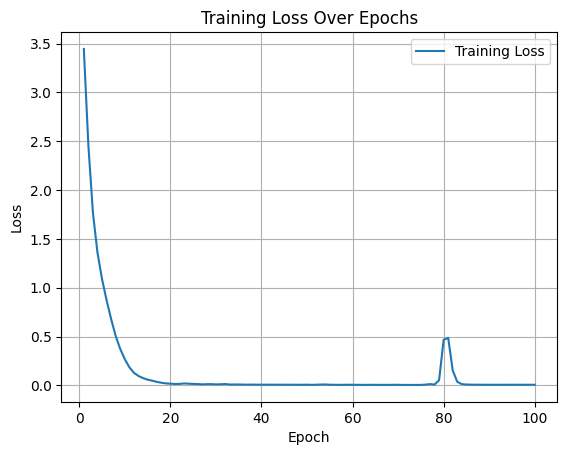

In [41]:
# Plot the loss graph
plt.plot(range(1, num_epochs + 1), loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## **12. Test Model**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Evaluates the trained model on a test sentence to predict its English translation. Displays the input Persian sentence and its predicted English translation.
    </font>
</div>

In [42]:
model.eval()
with torch.no_grad():
    test_sentence = "ما به مدرسه رفتیم"
    test_tokens = text_to_indices(test_sentence, tokenizer_fa, vocab_fa)
    test_tensor = torch.tensor(test_tokens, dtype=torch.long).unsqueeze(0)  # Shape: (1, sequence_length)
    output = model(test_tensor)  # Shape: (1, sequence_length, vocab_size)
    predicted_indices = torch.argmax(output, dim=-1).squeeze().tolist()  # Shape: (sequence_length)
    predicted_sentence = " ".join([list(vocab_en.keys())[list(vocab_en.values()).index(idx)] for idx in predicted_indices])
    print(f"Input: {test_sentence}")
    print(f"Predicted: {predicted_sentence}")

Input: ما به مدرسه رفتیم
Predicted: We were to school


<div style="background-color: gray; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
If my notebook was useful for you, please give me a upvote. Thank you for your support ❤️
    <hr style="color: green;"></font>
    <font size="6px">
        <a href="https://omidsakaki.ir/">Website</a>
        <br/>
         <a href="https://github.com/omid-sakaki-ghazvini">Github</a>
        <br/>
        <a href="http://linkedin.com/in/omid-sakaki-ghazvini-378687217">linkedin</a> 
    </font>
</div>